# CGH Referral of Fracture and Non-Fracture Patients using K-Nearest Neighbors (KNN)

In [120]:
# Basics
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import time
import os
import copy
import collections

# General ML
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Check library versions
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
print('scipy: {}'.format(scipy.__version__))
print('sklearn: {}'.format(sklearn.__version__))

pandas: 0.21.1
numpy: 1.12.1
matplotlib: 2.1.1
seaborn: 0.8.1
scipy: 1.0.0
sklearn: 0.19.1


## Topics for discussion

1. Demo of concept to clinicians
    - Data source
    - Making predictions with KNN
    - Initial results
    - Concept of KNN
        - Distance between test point and rest of data points
        - K nearest neighbors (shortest distance)
        - Predicted value = majority of labels of K nearest neighbors
    - Long term system integration
        - Auto-suggest (from model prediction) but allow manual adjustment
        - Build up training set
2. Data 
    - Missing values
    - Conversion into float type
3. Choice of model
    - KNN computational expensive
    - With suffer at inference when datasize is too large
4. Maintenance of model
    - Train and test set update
    - Model performance

## Demostration of KNN

In [3]:
# Load data
names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

df = pd.read_csv('iris.data.txt', header=None, names = names)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [74]:
# Useful information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal_length    150 non-null float64
sepal_width     150 non-null float64
petal_length    150 non-null float64
petal_width     150 non-null float64
class           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


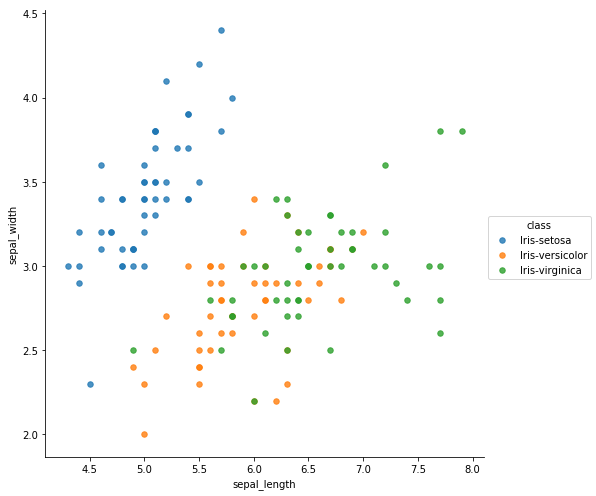

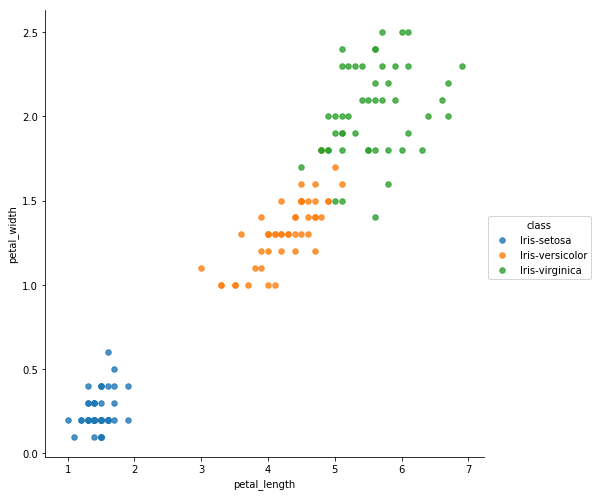

In [45]:
# Visually show the data
sns.lmplot(x='sepal_length', y='sepal_width', data=df, hue="class", fit_reg=False, scatter_kws={'marker':'D', 's':30}, size=7)
sns.lmplot(x='petal_length', y='petal_width', data=df, hue="class", fit_reg=False, scatter_kws={'marker':'D', 's':30}, size=7)

In [6]:
# Split features and labels from data set
X = np.array(df.iloc[:, 0:4]); 
Y = np.array(df['class'])

# Split into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

In [7]:
# Fit into a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
pred = knn.predict(X_test)

print("Parameters of KNN classifier:")
print(knn.get_params())
print('')

print("Predicted values as as follows:")
print(pred)
print('')

print("Actual values are as follows:")
print(Y_test)
print('')

print("Overall acccuracy: {}%".format(accuracy_score(Y_test, pred)))

Parameters of KNN classifier:
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}

Predicted values as as follows:
['Iris-versicolor' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-versicolor' 'Iris-setosa' 'Iris-versicolor' 'Iris-virginica'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris-setosa'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-virginica' 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica'
 'Iris-setosa' 'Iris-virginica' 'Iris-setosa' 'Iris-virginica'
 'Iris-virginica' 'Iris-virginica' 'Iris-virginica' 'Iris-virginica'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-versicolor'
 'Iris-setosa' 'Iris-setosa' 'Iris-virginica' 'Iris-versicolor'
 'Iris-setosa' 'Iris-setosa' 'Iris-setosa' 'Iris-virginica'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-setosa' 'Iris-setosa'
 'Iris-versicolor' 'Iris-versicolor' 'Iris-virginica' 'Iris

In [162]:
# Making prediction for a single example (No missing data point)
x = np.asarray([5.1,3.5,6.1,7.2]).reshape(1,-1)
pred_test = knn.predict(x)
print(pred_test)

['Iris-virginica']


In [69]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (5,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion matrix', fontsize=14)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    return heatmap

In [24]:
pred = pd.Series(pred)
pred.value_counts()

Iris-setosa        19
Iris-versicolor    16
Iris-virginica     15
dtype: int64

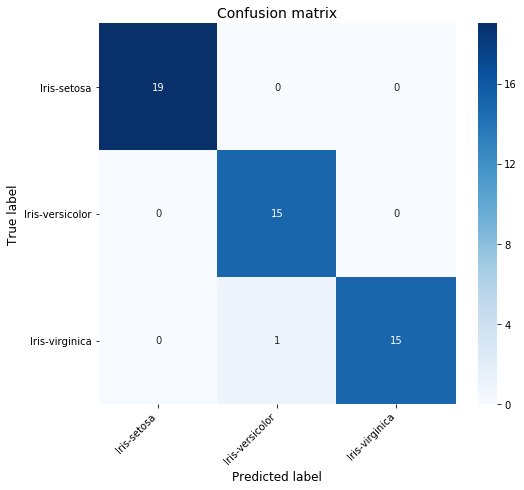

In [70]:
print_confusion_matrix(confusion_matrix(Y_test, pred), class_names= ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], figsize = (8,7), fontsize=10)

## What is KNN? (Code algo from scratch)
https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

In [81]:
def predict(X_train, Y_train, X_test, k):
    distances = []
    targets = []
    
    for i in range(len(X_train)):
        # Compute euclidean distance between test point and each and every training data point
        distance = np.sqrt(np.sum(np.square(X_test - X_train[i, :])))
        # Append to a list
        distances.append([distance, i])
        
    # Sort the list in increasing order
    distances = sorted(distances)
    
    # Make a list of k neighbor's targets
    for i in range(k):
        # Get index from top k lowest distances
        index = distances[i][1]
        # Get labels for these points with lowest distances
        targets.append(Y_train[index])
        
    # Return the most common target as predicted value
    return collections.Counter(targets).most_common(1)[0][0]

def kNearestNeighbor(X_train, Y_train, X_test, predictions, k):
    
    # Loop over all test data
    for i in range(len(X_test)):
        # Append each prediction for each test point into a list
        predictions.append(predict(X_train, Y_train, X_test[i,:], k))

In [141]:
predictions = []

kNearestNeighbor(X_train, Y_train, X_test, predictions, 5)
predictions = np.asarray(predictions)

acc = accuracy_score(Y_test, predictions)
print('The accuracy of our classifier is {}%.'.format(acc*100))

The accuracy of our classifier is 98.0%.


## Pros and Cons of KNN

Pros

- Simple to understand and easy to implement. 
- With zero to little training time, it can be a useful tool for off-the-bat analysis of some data set you are planning to run more complex algorithms on. 
- Furthermore, KNN works just as easily with multiclass data sets whereas other algorithms are hardcoded for the binary setting. 
- Finally, as we mentioned earlier, the non-parametric nature of KNN gives it an edge in certain settings where the data may be highly “unusual”.

Cons

- Computationally expensive testing phase which is impractical in industry settings. Note the rigid dichotomy between KNN and the more sophisticated Neural Network which has a lengthy training phase albeit a very fast testing phase. 
- Furthermore, KNN can suffer from skewed class distributions. For example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common). 
- Finally, the accuracy of KNN can be severely degraded with high-dimension data because there is little difference between the nearest and farthest neighbor.

## Improving the model

### Using GridSearch CV

Valid options for scoring in GridSearchCV are:

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [146]:
# Create list of odd numbers for fitting knn models. Avoid even to prevent ties.
kList = list(range(1,50))
k_values = np.array(list(filter(lambda x: x % 2 != 0, kList)))
param_grid = dict(n_neighbors=k_values)

# Use GridSearchCV to obtain optimal value of k
num_folds = 10
seed = 42
scoring = 'accuracy'
model = KNeighborsClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed)

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print('Best Acc: {0}% using {1}\n'.format(grid_result.best_score_*100, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('Accuracy(%)  Std(%)   Param')
    print('{0}         ({1:.2f})   with: {2}'.format(mean*100, stdev*100, param))

Best Acc: 94.0% using {'n_neighbors': 1}

Accuracy(%)  Std(%)   Param
94.0         (6.63)   with: {'n_neighbors': 1}
Accuracy(%)  Std(%)   Param
94.0         (6.63)   with: {'n_neighbors': 3}
Accuracy(%)  Std(%)   Param
94.0         (6.63)   with: {'n_neighbors': 5}
Accuracy(%)  Std(%)   Param
93.0         (6.40)   with: {'n_neighbors': 7}
Accuracy(%)  Std(%)   Param
93.0         (6.40)   with: {'n_neighbors': 9}
Accuracy(%)  Std(%)   Param
94.0         (6.63)   with: {'n_neighbors': 11}
Accuracy(%)  Std(%)   Param
93.0         (6.40)   with: {'n_neighbors': 13}
Accuracy(%)  Std(%)   Param
93.0         (6.40)   with: {'n_neighbors': 15}
Accuracy(%)  Std(%)   Param
93.0         (6.40)   with: {'n_neighbors': 17}
Accuracy(%)  Std(%)   Param
91.0         (8.31)   with: {'n_neighbors': 19}
Accuracy(%)  Std(%)   Param
93.0         (7.81)   with: {'n_neighbors': 21}
Accuracy(%)  Std(%)   Param
93.0         (6.40)   with: {'n_neighbors': 23}
Accuracy(%)  Std(%)   Param
91.0         (7.00)   w

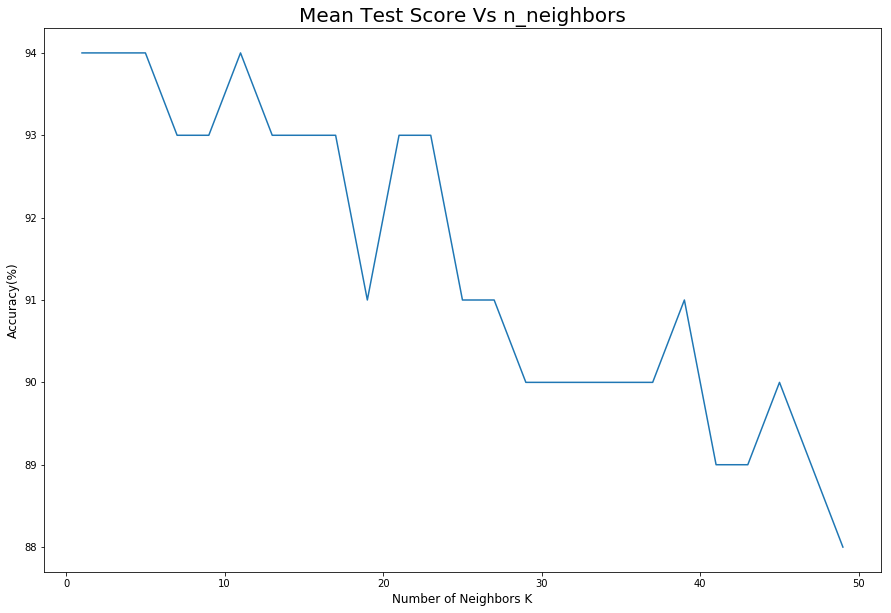

In [139]:
fig = plt.figure(figsize=(15,10))
plt.plot(k_values, means*100)
plt.title('Mean Test Score Vs n_neighbors', fontsize=20)
plt.ylabel('Accuracy(%)', fontsize=12)
plt.xlabel('Number of Neighbors K', fontsize=12)
plt.show()